In [ ]:
#default_exp lightcurve
%load_ext autoreload
from nbdev.showdoc import show_doc

# Light Curve Generation
> Generate light curves from cells

A "light curve" is a table with columns

- `t` -- time in MJD 
- `tw` -- the cell width
- `n`  -- number of photons
- `e`  -- relative exposure
- `fit` -- the fit object, containing info about the flux. This is usually a `PoissonRep` object

It is generated from a set of cells

Implemented here:

- `get_lightcurve`
- `fit_cells`
- `flux_plot`

In [ ]:
#export
import numpy as np
import pylab as plt
import pandas as pd
from light_curves.config import Config,  PointSource
from light_curves.loglike import (LogLike, GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable)
from light_curves.cells import get_cells

In [ ]:
#export
class _LightCurve(object):
    """ Apply likelihood fits to a set of cells
    
    parameters:
       - cells : a table with index t, columns  tw, n, e, w, S, B
       - min_exp : minimum fractional exposure allowed
       - rep_name : represention to use 

    Generates a DataTable with columns n, ep, fit
        
    """

    rep_class =  [GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable]
    rep_list =   'gauss gauss2d poisson poissontable'.split()

    def __init__(self, config, 
                all_cells, 
                source, 
                min_exp:  'minimum exposure factor'= 0.3,
                rep_name: 'likelihood rep name'='',
    
                ):
        """Apply fits to the likelihoods for a set of cells
        
 
        """

        self.source_name = source.name
 
        # select the set of cells
        cells = all_cells.query(f'e>{min_exp}').copy()
        
        # generate a list of LogLike objects for each
        cells.loc[:,'loglike'] = cells.apply(LogLike, axis=1)
        if config.verbose>0:
            print(f'Loaded {len(cells)} / {len(all_cells)} cells with exposure >'\
                  f' {min_exp} for light curve analysis')
            print(f'first cell: {cells.iloc[0]}')

        # analyze using selected rep
        rep_name = rep_name or config.likelihood_rep
        
        if rep_name not in self.rep_list:
            raise Exception(f'Unrecognized rep: "{rep_name}", must be one of {self.rep_list}')
        repcl = self.rep_class[self.rep_list.index(rep_name)]

        if config.verbose>1:
            print(f'Fitting likelihoods with {rep_name} representation')
        
        # making output with reduced columns 
        self.ll_fits = cells['t tw n e'.split()].copy()
        self.ll_fits.loc[:,'fit'] = cells.loglike.apply(repcl)

    def __repr__(self):
        return f'{self.__class__.__name__}: source "{self.source_name}" fit with {len(self.ll_fits)} cells'


    @property
    def dataframe(self):
        """return the DataFrame
        """
        return self.ll_fits

In [ ]:
#export
def fit_cells(config, 
            input_cells, 
            min_exp:  'minimum exposure factor'= 0.3,
            repcl = PoissonRep,

            ):
    """Apply fits to the likelihoods for a set of cells
    return light-curve dataframe

    """

    # select the set of cells
    cells = input_cells.query(f'e>{min_exp}').copy()

    # generate a list of LogLike objects for each
    cells.loc[:,'loglike'] = cells.apply(LogLike, axis=1)
    if config.verbose>0:
        print(f'Loaded {len(cells)} / {len(input_cells)} cells with exposure >'\
              f' {min_exp} for fitting')
  
    # making output with reduced columns 
    ll_fits = cells['t tw n e'.split()].copy()
    ll_fits.loc[:,'fit'] = cells.loglike.apply(repcl)
    
    return ll_fits

In [ ]:
#export    


def get_lightcurve(config,  source, bin_edges=None, key=''):
    """Returns a lightcurve table for the source
    
    - `source` -- a PointSource object
    - `bin_edges` -- optional to select other than default described in config
    - `key` -- optional cache key. Set to None to disable cache use
    
    """
    def doit():
        cells = get_cells(config,  source, bin_edges)
        lc = _LightCurve(config, cells, source).dataframe
        return lc
        
    if bin_edges is None:
        # use cache only with default bins
        key = f'lightfcurve_{source.name}' if key=='' else  key 
        description = f'Light curve for {source.name}' if config.verbose>0 and key is not None else '' 
        return config.cache(key, doit, description=description)
    else:
        return doit()

In [ ]:
#collapse_hide

def test_lc():
    config = Config()
    source = PointSource('Geminga')
    if not config.valid:
        return
    print(f'Loading cells with source {source.name}')
    lc = get_lightcurve(config,  source,  key=None)
    assert lc is not None
    print(f'LIght curve has {len(lc)} cells')
    c = lc.iloc[0]
    print(f'\nFirst cell fit: {c["fit"]}')
    return lc

if Config().valid:
    lc = test_lc()
    if lc is not None:
        lc.head()

Loading cells with source Geminga
Cell data for Geminga: Restoring from cache with key "cells_Geminga"
Loaded 3873 / 4015 cells with exposure > 0.3 for light curve analysis
first cell: t                                                    54683.5
tw                                                         1
e                                                    1.26456
n                                                        330
w          [244, 214, 174, 5, 246, 150, 187, 65, 91, 215,...
S                                                    225.585
B                                                    114.707
loglike    light_curves.loglike.LogLike:  time 54683.500,...
Name: 0, dtype: object
Fitting likelihoods with poisson representation
LIght curve has 3873 cells

First cell fit:   0.927[1+0.076-0.079], < 1.05


In [ ]:
#export
def flux_plot(config, lightcurve, ts_min=9,  
              title=None, ax=None, fignum=1, figsize=(12,4),
              step=False, 
              tzero:'time offset'=0,
              colors=('cornflowerblue','sandybrown', 'blue'), fmt=' ',
              **kwargs): 
    """Make a plot of flux vs. MJD
    
    - lightcurve 
    - ts_min -- threshold for ploting signal 
    - colors -- tuple of colors for signal, limit, step
    - tzero -- time offset
    - kwargs -- apply to the Axis object
    - step   -- add a "step" plot
    
    returns the Figure instance
    """
    kw=dict(yscale='linear',
            xlabel='MJD'+ f' - {tzero}' if tzero else '' ,
            ylabel='relative flux')
    kw.update(**kwargs)
    df=lightcurve
    rep = config.likelihood_rep
    if rep =='poisson':
        ts = df.fit.apply(lambda f: f.ts) 
        limit = ts<ts_min
        bar = df.loc[~limit,:]
        lim = df.loc[limit,:]
        allflux= np.select([~limit, limit], 
                        [df.fit.apply(lambda f: f.flux).values,
                         df.fit.apply(lambda f: f.limit).values],
                       )
        
    else: 
        bar=df; lim=[]

    fig, ax = plt.subplots(figsize=figsize, num=fignum) if ax is None else (ax.figure, ax)\
        if ax is not None else (ax.figure,ax)

    # the points with error bars
    t = bar.t.values-tzero
    tw = bar.tw.values 
    fluxmeas = allflux[~limit]
    upper = bar.fit.apply(lambda f: f.errors[1]).values
    lower = bar.fit.apply(lambda f: f.errors[0]).values
    error = np.array([upper-fluxmeas, fluxmeas-lower])

#     if rep=='poisson':
#         dy = [bar.errors.apply(lambda x: x[i]).clip(0,4) for i in range(2)]
#     elif rep==='gauss' or rep=='gauss2d':
#         dy = bar.sig_flux.clip(0,4)
#     else: assert False, f'Unrecognized likelihood rep: {rep}'   

    ax.errorbar(x=t, xerr=tw/2, y=fluxmeas, yerr=error, fmt=fmt, color=colors[0], )#'silver')

    if step:
        t = df.t.values-tzero
        xerr = df.tw.values/2; 
        x = np.append(t-xerr, [t[-1]+xerr[-1]]); 
        y = np.append(allflux, [allflux[-1]])
        ax.step(x, y, color=colors[2], where='post', lw=2)

    
    # now do the limits (only for poisson rep)
    error_size=2
    if len(lim)>0:
        t = lim.t-tzero
        tw = lim.tw 

        y = allflux[limit]
        yerr=0.2*(1 if kw['yscale']=='linear' else y)
        ax.errorbar(x=t, y=y, xerr=tw/2,
                yerr=yerr,  color=colors[1], 
                uplims=True, ls='', lw=error_size, capsize=3*error_size, capthick=0,
               )

    #ax.axhline(1., color='grey')
    ax.set(**kw)
    ax.set_title(title) # or f'{source_name}, rep {self.rep}')
    ax.grid(alpha=0.5)
    return fig

In [ ]:
show_doc(flux_plot)

<h4 id="flux_plot" class="doc_header"><code>flux_plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>flux_plot</code>(**`config`**, **`lightcurve`**, **`ts_min`**=*`9`*, **`title`**=*`None`*, **`ax`**=*`None`*, **`fignum`**=*`1`*, **`figsize`**=*`(12, 4)`*, **`step`**=*`False`*, **`tzero`**:`time offset`=*`0`*, **`colors`**=*`('cornflowerblue', 'sandybrown', 'blue')`*, **`fmt`**=*`' '`*, **\*\*`kwargs`**)

Make a plot of flux vs. MJD

- lightcurve 
- ts_min -- threshold for ploting signal 
- colors -- tuple of colors for signal, limit, step
- tzero -- time offset
- kwargs -- apply to the Axis object
- step   -- add a "step" plot

returns the Figure instance

Example plot-- the first 100 days of Fermi data for Geminga

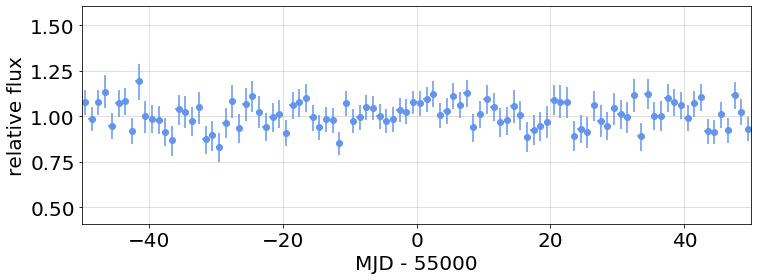

In [ ]:
#collapse_hide
config = Config()
if config.valid:
    
    plt.rc('font', size=20)
    fig, ax = plt.subplots(figsize=(12,4))
    flux_plot(config, lc, fmt='o', ax=ax, xlim=(-50,50), step=False, tzero=55000)

    
    

And forcing upper limits

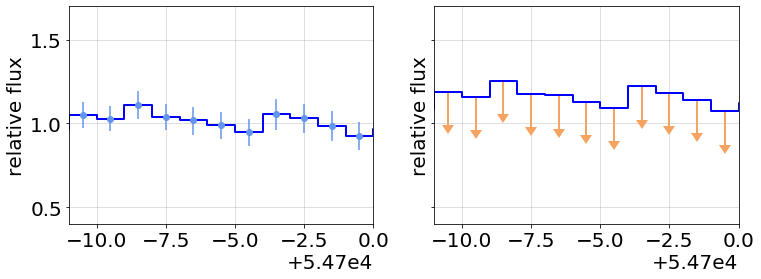

In [ ]:
#collapse_hide
if config.valid:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
    flux_plot(config, lc, ax=ax1, fmt='o', xlim=(54689, 54700),  step=True)
    flux_plot(config, lc, ax=ax2, fmt='o', xlim=(54689, 54700), ts_min=1000, step=True)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_gti.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cells.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 13_kerr_comparison.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_analysis.ipynb.
Converted index.ipynb.
Sat Dec 19 16:57:28 PST 2020
